<a href="https://colab.research.google.com/github/shivanshu1641/OCR-using-COCO-TEXT/blob/main/Group_1_Data_Prep_(Colab_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Akash Singh TE COMP B 27

# **Importing Modules**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import os
from os import path
from os import walk
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import shutil 
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
import keras
import skimage.io as io
import pylab
import pandas as pd
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# **Load Dataset**

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/My Drive/coco_text_master.zip"
shutil.move('/content/coco-text-master/coco_text.py','/content')  
shutil.move('/content/coco-text-master/coco_evaluation.py','/content')

Archive:  /content/coco_text_master.zip
38f8490fa7281872f588ae693f551cedbe2c0129
   creating: coco-text-master/
  inflating: coco-text-master/README.md  
  inflating: coco-text-master/coco_evaluation.py  
  inflating: coco-text-master/coco_text.py  
  inflating: coco-text-master/coco_text_Demo.ipynb  
  inflating: coco-text-master/our_results.json  


'/content/coco_evaluation.py'

## Import COCO API

In [ ]:
import coco_text
import coco_evaluation

# Load Dataset using PyDrive


Before loading lets have a look about our dataset.


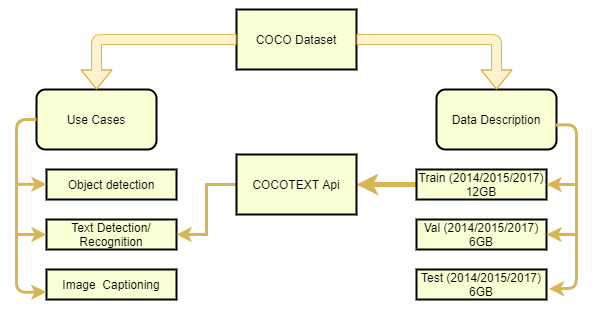

In [ ]:
#Access Google Drive
data = drive.CreateFile({'id':"1dFkw4M1TxLi-A9L4T1EMmM6T8zNyrbLJ"})
data.GetContentFile("train.zip")

In [ ]:
data = drive.CreateFile({'id':"1Ig3WP-hymxo-JqgXGwS31PeAmZlxjojm"})
data.GetContentFile("train.z01")

In [ ]:
data = drive.CreateFile({'id':"1puiuGCTRcRHtsJsOoEHGj-2z2U6_3lrN"})
data.GetContentFile("train.z02")

In [ ]:
data = drive.CreateFile({'id':"1yVz6owIP3Lwb381gSOodaMZdGElcRfMH"})
data.GetContentFile("train.z03")

In [ ]:
!zip -F "/content/train.zip" --out "/content/train-large.zip"

In [ ]:
!unzip "/content/train-large.zip"
#After this unzipping finishes delete the files that were loaded from drive

# **Inspect Dataset**

## Count of Train, Val and Test Images

In [ ]:
path, dirs, files = next(os.walk("/content/train2014"))
file_count = len(files)
print(file_count)

82783


In [ ]:
data = drive.CreateFile({'id':"1qQODsUAe4sF-yUR-906gn4okYHcBi1Pu"})
data.GetContentFile("COCO_TEXT.zip")
!unzip "/content/COCO_TEXT.zip"


Archive:  /content/COCO_TEXT.zip
  inflating: COCO_Text.json          


In [ ]:
dataDir='/content'
dataType='train2014'

In [ ]:
ct = coco_text.COCO_Text('/content/COCO_Text.json')

loading annotations into memory...
0:00:02.543841
creating index...
index created!


In [ ]:
ct.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [ ]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train ,catIds=[('legibility','legible'),('class','machine printed')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.train ,catIds=[('legibility','ilegible'),('class','machine printed')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.train ,catIds=[('legibility','legible'),('class','handwritten')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.train ,catIds=[('legibility','ilegible'),('class','handwritten')])
print(len(imgIds))

14324
0
1074
0


In [ ]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.val ,catIds=[('legibility','legible'),('class','machine printed')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.val ,catIds=[('legibility','ilegible'),('class','machine printed')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.val ,catIds=[('legibility','legible'),('class','handwritten')])
print(len(imgIds))
imgIds = ct.getImgIds(imgIds=ct.val ,catIds=[('legibility','ilegible'),('class','handwritten')])
print(len(imgIds))

3346
0
242
0


In [ ]:
imgIds_train= ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
imgIds_val= ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible')])

## Number of Images

In [ ]:
images_in_annotation_train = []
images_in_annotation_val = []
for idx in range(len(imgIds_train)):
  x = ct.loadImgs(imgIds_train[idx])[0]
  images_in_annotation_train.append('%s/%s/%s'%(dataDir,dataType,x['file_name']))
for idx in range(len(imgIds_val)):
  x = ct.loadImgs(imgIds_val[idx])[0]
  images_in_annotation_val.append('%s/%s/%s'%(dataDir,dataType,x['file_name']))

In [ ]:
print(len(images_in_annotation_train))
print(len(images_in_annotation_val))

15124
3522


In [ ]:
images_in_annotation_train[0]

'/content/train2014/COCO_train2014_000000294914.jpg'

## Dataset Split


In [ ]:
os.mkdir('/content/data')
os.mkdir('/content/data/Train')
os.mkdir('/content/data/Val')

In [ ]:
for source in images_in_annotation_train:
  shutil.copy(source, '/content/data/Train')  
for source in images_in_annotation_val:
  shutil.copy(source, '/content/data/Val')  


In [ ]:
f_train = []
for (dirpath, dirnames, filenames) in walk('/content/data/Train'):
    f_train.extend(filenames)
    break
print(len(f_train))

15124


In [ ]:
f_val = []
for (dirpath, dirnames, filenames) in walk('/content/data/Val'):
    f_val.extend(filenames)
    break
print(len(f_val))

3522


# Save the Zip


In [ ]:
shutil.make_archive("Data","zip",'/content/data')

'/content/Data.zip'